In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

import imgaug as ia
import matplotlib
import numpy as np
import torch
from livelossplot import PlotLosses
from matplotlib import pyplot as plt
from skorch.net import NeuralNet
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize, ToPILImage, ToTensor

from retinanet.encoder import DataEncoder
from retinanet.loss import *
from retinanet.loss import FocalLoss
from retinanet.retinanet import RetinaNet
from utils.pikachu_dataset import load_data_pikachu


matplotlib.rcParams['figure.figsize'] = [14, 10]


device  = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/i008/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:

class FocalLoss(nn.Module):
    def __init__(self, num_classes=20):
        super(FocalLoss, self).__init__()
        self.num_classes = num_classes

    def focal_loss(self, x, y):
        '''Focal loss.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        gamma = 2

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)  # [N,21]
        t = t[:,1:]  # exclude background
        t = Variable(t).cuda()  # [N,20]

        p = x.sigmoid().detach()
        pt = p*t + (1-p)*(1-t)         # pt = p if t > 0 else 1-p
        w = alpha*t + (1-alpha)*(1-t)  # w = alpha if t > 0 else 1-alpha
        w = w * (1-pt).pow(gamma)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)

    def focal_loss_alt(self, x, y):
        '''Focal loss alternative.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)
        t = t[:,1:]
        t = Variable(t).cuda()

        xt = x*(2*t-1)  # xt = x if t > 0 else -x
        pt = (2*xt+1).sigmoid() 

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / 2
        return loss.sum()

    def forward(self, loc_preds,loc_targets,cls_preds, cls_targets):
        '''Compute loss between (loc_preds, loc_targets) and (cls_preds, cls_targets).
        Args:
          loc_preds: (tensor) predicted locations, sized [batch_size, #anchors, 4].
          loc_targets: (tensor) encoded target locations, sized [batch_size, #anchors, 4].
          cls_preds: (tensor) predicted class confidences, sized [batch_size, #anchors, #classes].
          cls_targets: (tensor) encoded target labels, sized [batch_size, #anchors].
        loss:
          (tensor) loss = SmoothL1Loss(loc_preds, loc_targets) + FocalLoss(cls_preds, cls_targets).
        '''
        batch_size, num_boxes = cls_targets.size()
        pos = cls_targets > 0  # [N,#anchors]
        num_pos = pos.data.long().sum()

        ################################################################
        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        ################################################################
        mask = pos.unsqueeze(2).expand_as(loc_preds)       # [N,#anchors,4]
        masked_loc_preds = loc_preds[mask].view(-1,4)      # [#pos,4]
        masked_loc_targets = loc_targets[mask].view(-1,4)  # [#pos,4]
        loc_loss = F.smooth_l1_loss(masked_loc_preds, masked_loc_targets, size_average=False)

        ################################################################
        # cls_loss = FocalLoss(loc_preds, loc_targets)
        ################################################################
        pos_neg = cls_targets > -1  # exclude ignored anchors
        num_peg = pos_neg.data.long().sum()
        mask = pos_neg.unsqueeze(2).expand_as(cls_preds)
        masked_cls_preds = cls_preds[mask].view(-1,self.num_classes)
        
#         fl = FL()
#         cls_loss = self.focal_loss_alt(masked_cls_preds, cls_targets[pos_neg])
        cls_loss = self.focal_loss(masked_cls_preds, cls_targets[pos_neg])
#         print("clsloss: {} locloss: {}".format(cls_loss.item(), loc_loss.item()))
        pos = cls_targets > 0  # [N,#anchors]
        num_pos = pos.data.long().sum()
        num_pos_neg = pos_neg.data.long().sum()

        if num_pos > 0:
            loss = (cls_loss + loc_loss) / num_pos
        elif num_pos_neg > 0:
            loss = cls_loss
        else:
            raise Exception('num_pos_neg == 0')
            
        loss = loc_loss + cls_loss
        return loss
           

    
    
class PikachuDataset(Dataset):
    def __init__(self, anchor_areas=None):
        
        self.anchor_areas = anchor_areas
        self.train, self.val = load_data_pikachu(1)
        if anchor_areas is not None:
            encoder = DataEncoder(anchor_areas=anchor_areas)
        else:
            encoder = DataEncoder()            
        self.encoder = encoder 
        
    def __len__(self):
        return 900
        
    def __getitem__(self, i):
        try:
            b = self.train.next()
        except StopIteration:
            self.train.reset()
            b = self.train.next()
            
        image = b.data[0].asnumpy()
        bbox = b.label[0].asnumpy()[:, 0, 1:] * 256
        label = b.label[0].asnumpy()[:, 0, 0]
    
        return torch.from_numpy(image), torch.from_numpy(bbox), torch.from_numpy(label)
    
    def collate_func(self, batch):
        
        images = [b[0][0] for b in batch]
        bbox = [b[1] for b in batch]
        labels = [b[2] for b in batch]
        
        
        encoded = [self.encoder.encode(bb, l, torch.Tensor([256, 256])) for bb, l in zip(bbox, labels)]
        
        
        loc_target = [l[0] for l in encoded]
        cls_target = [l[1] for l in encoded]
        

        return torch.stack(images) / 255, torch.stack(loc_target), torch.stack(cls_target)
        
        
def down_sample(in_channels,out_channels):
    
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1), 
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1), 
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(),
        nn.MaxPool2d(2,2)       
    )

class SimpleSSD(nn.Module):
    
    
    def __init__(self, n_cls=1, num_anchors=9):
        super(SimpleSSD, self).__init__()
        
        self.n_cls = n_cls
        self.num_anchors = num_anchors
        
        
        # Base CNN (think resnet/vgg or other base network)
        self.step1 = down_sample(3, 128)
        self.step2 = down_sample(128, 128)
        self.step3 = down_sample(128, 128)
        self.step4 = down_sample(128, 128)
        self.step5 = down_sample(128, 128)


        self.cls_head1 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head1 = nn.Conv2d(128, self.num_anchors *4, 3, padding=1)
        
        self.cls_head2 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head2 = nn.Conv2d(128,self.num_anchors * 4,3, padding=1)
        
        self.cls_head3 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head3 = nn.Conv2d(128, self.num_anchors * 4,3, padding=1)
        
        
    def forward(self, x):
        
        
        step1=self.step1(x)
        step2=self.step2(step1)

        step3=self.step3(step2)
        step4 = self.step4(step3)
        step5 = self.step5(step4)
                
        cls1 = self.cls_head1(step3)
        bbox1 = self.bbox_head1(step3)
        
        cls2 = self.cls_head2(step4)
        bbox2 = self.bbox_head2(step4)
        
        cls3 = self.cls_head3(step5)
        bbox3 = self.bbox_head3(step5) 

    
        cls1 = cls1.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls2 = cls2.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls3 = cls3.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        
        bbox1 = bbox1.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox2 = bbox2.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox3 = bbox3.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
      
        cls_pred = torch.cat([cls1, cls2, cls3], dim=1)
        bbox_pred = torch.cat([bbox1, bbox2, bbox3], dim=1)
        
        return bbox_pred, cls_pred
                


In [27]:
pikachu_ds =PikachuDataset(anchor_areas=[30*30, 50*50, 90*90])
pikachu_dl = DataLoader(pikachu_ds, batch_size=2, collate_fn=pikachu_ds.collate_func)

next(iter(pikachu_dl))


(tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.6706, 0.6706, 0.6706],
           [0.5765, 0.5765, 0.5765,  ..., 0.6667, 0.6667, 0.6667],
           [0.5569, 0.5569, 0.5569,  ..., 0.6706, 0.6667, 0.6627],
           ...,
           [0.3294, 0.2745, 0.2667,  ..., 0.9647, 0.9569, 0.9569],
           [0.2667, 0.2392, 0.2510,  ..., 0.9765, 0.9686, 0.9647],
           [0.2000, 0.2353, 0.2627,  ..., 0.9843, 0.9725, 0.9686]],
 
          [[0.7961, 0.7961, 0.7961,  ..., 0.8431, 0.8431, 0.8431],
           [0.7843, 0.7843, 0.7843,  ..., 0.8392, 0.8392, 0.8392],
           [0.7725, 0.7725, 0.7725,  ..., 0.8353, 0.8314, 0.8353],
           ...,
           [0.4353, 0.3804, 0.3569,  ..., 1.0000, 0.9922, 0.9804],
           [0.3686, 0.3373, 0.3412,  ..., 1.0000, 0.9961, 0.9843],
           [0.2941, 0.3294, 0.3529,  ..., 0.9961, 0.9961, 0.9843]],
 
          [[0.9843, 0.9843, 0.9843,  ..., 0.9961, 0.9961, 0.9961],
           [0.9843, 0.9843, 0.9843,  ..., 0.9922, 0.9922, 0.9922],
           [0.9804, 0.98

In [28]:
model= SimpleSSD(1)
model = model.to(device)
criterion = FocalLoss(num_classes=1)
plot_losses = PlotLosses()

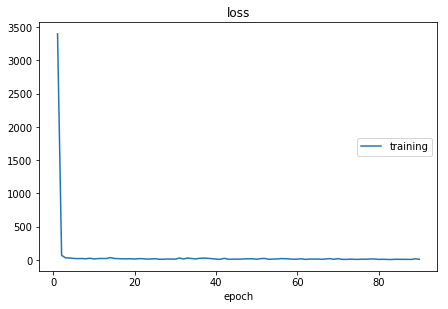

loss:
training   (min:    5.239, max: 3400.736, cur:    8.622)


In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
collect = []

for epoch in range(2): 
    for i, b in enumerate(pikachu_dl):
        logs = {}
        optimizer.zero_grad()
        image, bounding_boxes, labels = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        optimizer.step()
        collect.append([total_loss.detach().cpu().numpy()])
        logs['loss'] = total_loss.item()
        if i % 10 == 0:
            plot_losses.update(logs)
            plot_losses.draw()


# Visualize

In [19]:
it = iter(pikachu_dl)

Text(0.5,1,'score tensor([0.5018, 0.5018, 0.4687, 0.4687, 0.4525, 0.4525, 0.4264, 0.4264, 0.4215,\n        0.4215, 0.3088, 0.3088], grad_fn=<IndexBackward>)')

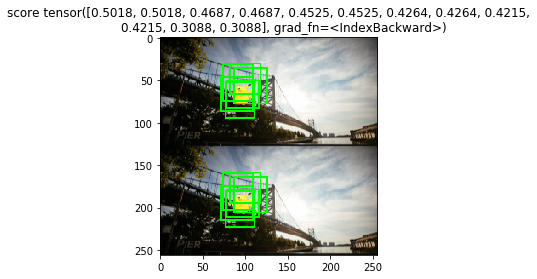

In [26]:

b = next(it)

im = ToTensor()(Resize((256, 256))(ToPILImage()(torch.cat([b[0][0], b[0][0]], dim=1))))
image = im.unsqueeze(0)

enc = DataEncoder(anchor_areas=[30*30, 50*50, 90*90])
loc_pred, cls_pred = model(image.cuda())

i = 0
bbspred, labelpred, score  = enc.decode(
    loc_pred[i].float().cpu(), 
    cls_pred[i].float().cpu(), 
    torch.Tensor([256, 256]).float().cpu()
)

image_to_show = np.moveaxis(
    image[i].detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=2)
plt.imshow(image_to_show)
plt.title('score ' + str(score))

### Exercises

-  Load a custom image with pikachu( or many ) and try to make predictiosn with the network and visualize the result
-  Can you think of anything that could confuse our detector? yellow dots ?
- Currently the code is not really modular, try to make it nice by splitting it into logical parts
    - Base feature extractor Module
    - Head Creator module
- Currently the detection/cls HEADS are very simple (just one CONV layer) they can be more complex. Try using more convolutions, check other architectures how its done

- Can you use our network to train using some new data for instance:
    - https://www.kaggle.com/tomluther/ships-in-google-earth
    - https://www.kaggle.com/aruchomu/data-for-yolo-v3-kernel
    - https://www.kaggle.com/dataturks/face-detection-in-images
    - https://www.kaggle.com/dataturks/face-dataset-with-age-emotion-ethnicity  
 You will need to create a data loader/data sets similar as we did for the pikachu loader. 


In [ ]:
score